## Import libraries

In [1]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as T
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

import random
import time

from sklearn.preprocessing import OneHotEncoder,LabelEncoder
import numpy as np
import glob
from sklearn.utils import shuffle
from PIL import Image
from tqdm.notebook import tqdm, trange
from collections import OrderedDict
import itertools

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 1. Dataset 
In this notebook, I used Imagenette dataset (320px version): https://github.com/fastai/imagenette. I chose 5 different classes out of 10.

#### Loading the dataset


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
classes = np.unique(["English_springer", "chain_saw", "church", "French_horn", "golf_ball"])

In [5]:
train_English_springer = glob.glob(r"/content/drive/MyDrive/imagenette2-320/train/English springer/*")
train_chain_saw = glob.glob(r"/content/drive/MyDrive/imagenette2-320/train/chain saw/*")
train_church = glob.glob(r"/content/drive/MyDrive/imagenette2-320/train/church/*")
train_French_horn = glob.glob(r"/content/drive/MyDrive/imagenette2-320/train/French horn/*")
train_golf_ball = glob.glob(r"/content/drive/MyDrive/imagenette2-320/train/golf ball/*")

val_English_springer = glob.glob(r"/content/drive/MyDrive/imagenette2-320/val/English springer/*")
val_chain_saw = glob.glob(r"/content/drive/MyDrive/imagenette2-320/val/chain saw/*")
val_church = glob.glob(r"/content/drive/MyDrive/imagenette2-320/val/church/*")
val_French_horn = glob.glob(r"/content/drive/MyDrive/imagenette2-320/val/French horn/*")
val_golf_ball = glob.glob(r"/content/drive/MyDrive/imagenette2-320/val/golf ball/*")

In [6]:
train_paths = train_English_springer + train_chain_saw + train_church + train_French_horn + train_golf_ball
val_paths = val_English_springer + val_chain_saw + val_church + val_French_horn + val_golf_ball

In [7]:
print(f"There are {len(train_paths)} photos in the Train folder.")
print(f"There are {len(val_paths)} photos in the Val folder.")

There are 4670 photos in the Train folder.
There are 1992 photos in the Val folder.


In [8]:
train_labels = ["English_springer"] * len(train_English_springer) + \
               ["chain_saw"] * len(train_chain_saw) + \
               ["church"] * len(train_church) + \
               ["French_horn"] * len(train_French_horn) + \
               ["golf_ball"] * len(train_golf_ball)

In [9]:
val_labels = ["English_springer"] * len(val_English_springer) + \
               ["chain_saw"] * len(val_chain_saw) + \
               ["church"] * len(val_church) + \
               ["French_horn"] * len(val_French_horn) + \
               ["golf_ball"] * len(val_golf_ball)

#### Splitting the dataset

In [10]:
val_paths, val_labels = shuffle(val_paths, val_labels, random_state=42)

In [11]:
VALID_RATIO = 0.8
n1 = int(len(val_paths) * VALID_RATIO)
n2 = len(val_paths) - n1

valid_paths = val_paths[:n1]
valid_labels = val_labels[:n1]
test_paths = val_paths[n1:]
test_labels = val_labels[n1:]

In [12]:
print(f'Number of training examples: {len(train_paths)}')
print(f'Number of validation examples: {len(valid_paths)}')
print(f'Number of testing examples: {len(test_paths)}')

Number of training examples: 4670
Number of validation examples: 1593
Number of testing examples: 399


In [13]:
def plot_data(y_lst, classes, title, x_name, y_name):
  y = []
  for cls in classes:
    y.append(sum(map(lambda x : x == cls, y_lst)))
  plt.rcParams["figure.figsize"] = (10,6)
  plt.bar(classes, y) 
  for i in range(len(classes)):
      plt.text(i,y[i],y[i])  
  plt.title(title)
  plt.xlabel(x_name)
  plt.ylabel(y_name)
  plt.show()

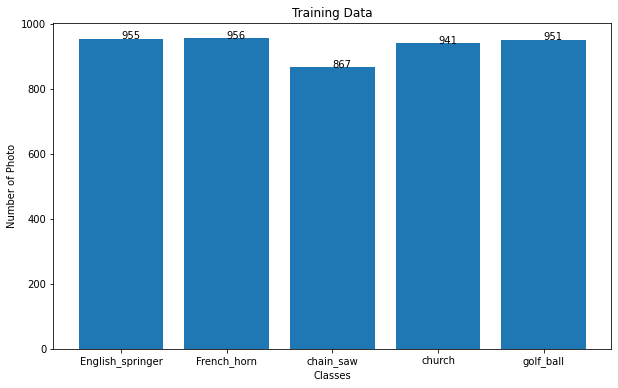

In [14]:
plot_data(train_labels, classes, "Training Data", "Classes", "Number of Photo")

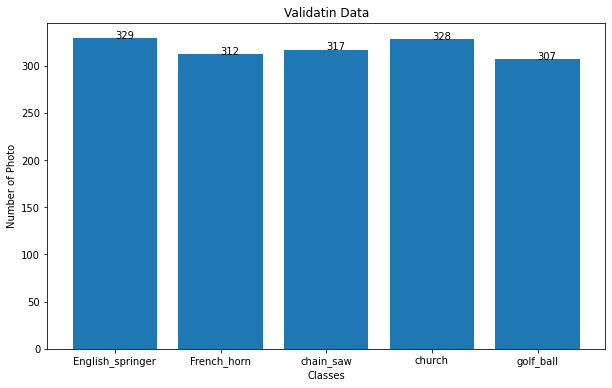

In [15]:
plot_data(valid_labels, classes, "Validatin Data", "Classes", "Number of Photo")

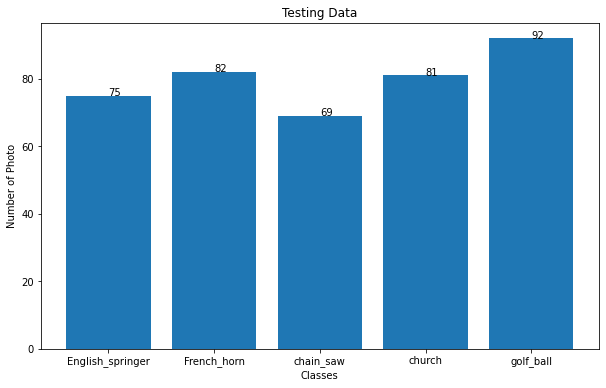

In [16]:
plot_data(test_labels, classes, "Testing Data", "Classes", "Number of Photo")

In [17]:
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(classes)

In [18]:
y_train  = label_encoder.transform(train_labels)
y_valid  = label_encoder.transform(valid_labels)
y_test  = label_encoder.transform(test_labels)

#### Pre-processing the dataset

In [19]:
class Imagenette_320px(Dataset):
    def __init__(self, paths, labels, transform=None):
      self.paths = paths
      self.labels = labels
      self.transform = transform
        
    def __len__(self):
      return len(self.paths)
    
    def __getitem__(self, index):
      path = self.paths[index]
      image = Image.open(path).convert("RGB")
      
      if self.transform:
          image = self.transform(image)
          
      label = self.labels[index]
      label = torch.tensor(label)
      
      return image, label

In [20]:
means, stds = [0.485,0.456,0.406], [0.229,0.224,0.225]

train_transform = T.Compose([
                           T.RandomRotation(degrees=(-5,+5)),
                           T.RandomHorizontalFlip(0.1),
                           #T.RandomCrop(10, padding=2),
                           T.Resize(size=(320,320)),
                           T.ToTensor(),
                           T.Normalize(mean=means, std=stds)
                           ])

test_transform = T.Compose([
                        T.Resize(size=(320,320)),
                        T.ToTensor(),
                        T.Normalize(mean=means, std=stds)
                        ])

In [21]:
train_dataset = Imagenette_320px(train_paths, y_train, train_transform)
test_dataset = Imagenette_320px(test_paths, y_test, test_transform)
valid_dataset = Imagenette_320px(valid_paths, y_valid, test_transform)

In [22]:
train_batch_size = 4
test_batch_size = 4
valid_batch_size = 4

train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=valid_batch_size, shuffle=True)

In [23]:
def show_image(image,label,get_denormalize = True):
    
    image = image.permute(1,2,0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    
    if get_denormalize:
        image = image*std + mean
        image = np.clip(image,0,1)
        plt.imshow(image)
        plt.title(label)
        plt.axis('off')
        
    else: 
        plt.imshow(image)
        plt.title(label)
        plt.axis('off')


def show_grid(image):
    
    image = image.permute(1,2,0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    
    image = image*std + mean
    image = np.clip(image,0,1)
    
    plt.figure(figsize=[15, 15])
    plt.imshow(image)
    plt.axis('off')

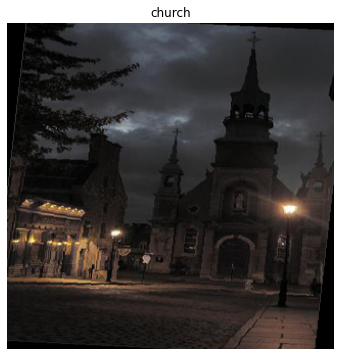

In [24]:
I, L  = train_dataset[random.randint(0,len(train_dataset))]

show_image(I, label_encoder.inverse_transform([L])[0]   ,   get_denormalize = True)

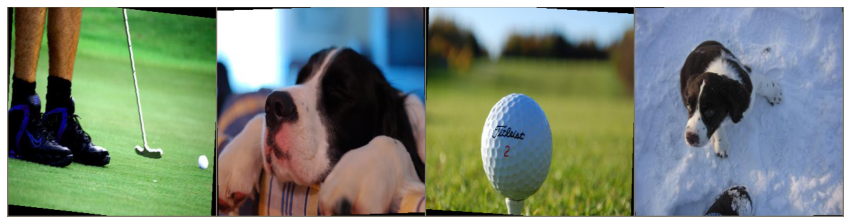

In [25]:
dataiter = iter(train_loader)
Images , Labels = dataiter.next()

out = make_grid(Images , nrow = 4)
show_grid(out)

## 2. Convolutional Neural Network Architecture


#### Load the architecture

In [26]:
model = torchvision.models.mobilenet_v2(pretrained=True)


# Freeze conv layers
for param in model.parameters():
    param.requires_grad = False


# Add one layer
model.classifier[1] = nn.Linear(model.last_channel, 5)
print(model.classifier)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=5, bias=True)
)


In [27]:
# Create list of params to learn
params_to_learn = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_learn.append(param)

#### Define an optimizer and loss function

In [28]:
optimizer = torch.optim.RMSprop(params_to_learn, lr=0.0001, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0.9, centered=False)
# optimizer = optim.Adam(params_to_learn)
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [29]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

#### Train the network

In [30]:
def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [31]:
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [32]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [33]:
EPOCHS = 25

best_valid_loss = float('inf')
error_going_up = 0
best_epoch = -1

history = {}
history['train_loss'] = []
history['train_acc'] = []
history['valid_loss'] = []
history['valid_acc'] = []

for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)


    valid_loss, valid_acc = evaluate(model, valid_loader, criterion, device)
    history['valid_loss'].append(valid_loss)
    history['valid_acc'].append(valid_acc)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut2-model.pt')

        # Early stopping implementation
        #error_going_up = 0
        #best_model = model
        best_epoch = epoch
    else:
        error_going_up += 1
        if error_going_up == 5:
            print('Training was terminated with early stopping on epoch: ' + str(epoch) + '. Best epoch:' + str(best_epoch+1))
            break 

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'\nEpoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epochs:   0%|          | 0/25 [00:00<?, ?it/s]

Training:   0%|          | 0/1168 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/399 [00:00<?, ?it/s]


Epoch: 01 | Epoch Time: 13m 32s
	Train Loss: 0.403 | Train Acc: 86.43%
	 Val. Loss: 0.055 |  Val. Acc: 97.62%


Training:   0%|          | 0/1168 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/399 [00:00<?, ?it/s]


Epoch: 02 | Epoch Time: 13m 2s
	Train Loss: 0.272 | Train Acc: 90.69%
	 Val. Loss: 0.021 |  Val. Acc: 99.44%


Training:   0%|          | 0/1168 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/399 [00:00<?, ?it/s]


Epoch: 03 | Epoch Time: 12m 55s
	Train Loss: 0.270 | Train Acc: 91.16%
	 Val. Loss: 0.032 |  Val. Acc: 99.00%


Training:   0%|          | 0/1168 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/399 [00:00<?, ?it/s]


Epoch: 04 | Epoch Time: 12m 53s
	Train Loss: 0.271 | Train Acc: 91.33%
	 Val. Loss: 0.024 |  Val. Acc: 99.31%


Training:   0%|          | 0/1168 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/399 [00:00<?, ?it/s]


Epoch: 05 | Epoch Time: 12m 49s
	Train Loss: 0.273 | Train Acc: 91.52%
	 Val. Loss: 0.032 |  Val. Acc: 98.81%


Training:   0%|          | 0/1168 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/399 [00:00<?, ?it/s]


Epoch: 06 | Epoch Time: 12m 45s
	Train Loss: 0.299 | Train Acc: 91.05%
	 Val. Loss: 0.021 |  Val. Acc: 99.19%


Training:   0%|          | 0/1168 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/399 [00:00<?, ?it/s]


Epoch: 07 | Epoch Time: 12m 55s
	Train Loss: 0.276 | Train Acc: 91.40%
	 Val. Loss: 0.024 |  Val. Acc: 99.31%


Training:   0%|          | 0/1168 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/399 [00:00<?, ?it/s]

Training was terminated with early stopping on epoch: 7. Best epoch:6


#### Show results (accuracy and loss) on training and validation sets

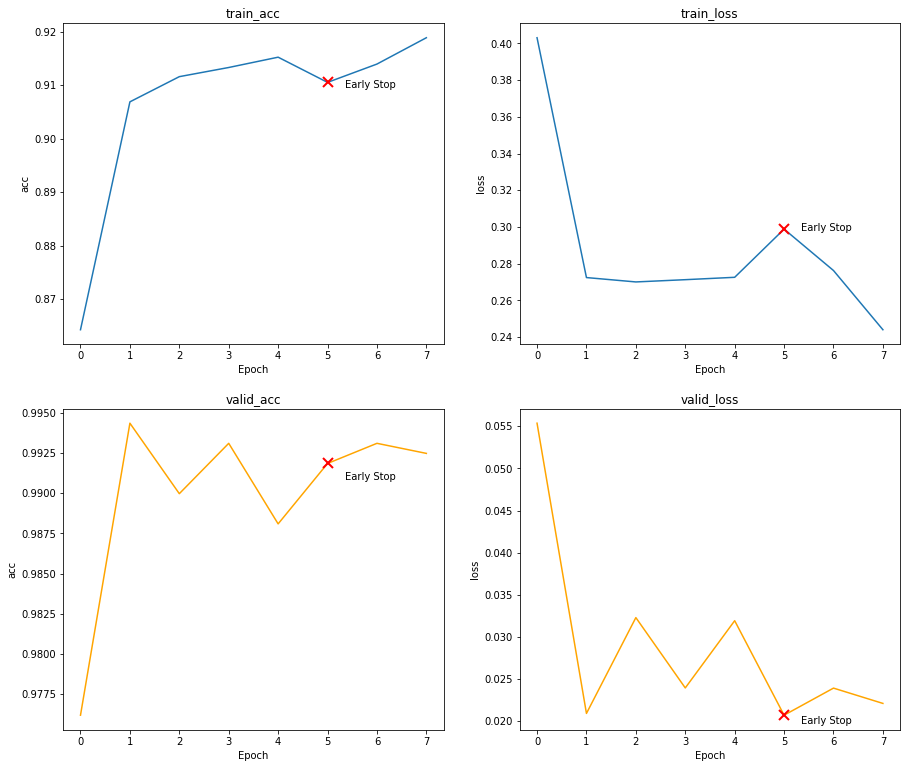

In [34]:
plt.figure(figsize=(15,13))
for i,name in enumerate(['train_acc','train_loss','valid_acc','valid_loss']):
    plt.subplot(2,2,i+1)

    if (name.split('_')[0]=='valid'):
        plt.plot(history[name], color='orange')
    else:
        plt.plot(history[name])

    plt.plot(best_epoch, history[name][best_epoch], color='red', marker='x', markersize=10, markeredgewidth='2')
    plt.annotate('Early Stop', xy = (best_epoch+0.35, history[name][best_epoch]-0.001))
    plt.title(name)
    plt.ylabel(name.split('_')[1])
    plt.xlabel('Epoch')
plt.show()

## 3. Conclusion (Evaluation)

#### Evaluate the model

In [35]:
model.load_state_dict(torch.load('/content/tut2-model.pt'))

test_loss, test_acc = evaluate(model, test_loader, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Test Loss: 0.012 | Test Acc: 99.25%


In [36]:
def get_predictions(model, iterator, device):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred = model(x)

            y_prob = F.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

In [37]:
images, labels, probs = get_predictions(model, test_loader, device)

In [38]:
pred_labels = torch.argmax(probs, 1)

In [39]:
pred_labels_names = []
labels_names = []
for i in range(len(pred_labels)):
  pred_labels_names.append(label_encoder.inverse_transform([pred_labels[i]])[0])
  labels_names.append(label_encoder.inverse_transform([labels[i]])[0])

In [40]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i,j], horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')
        
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

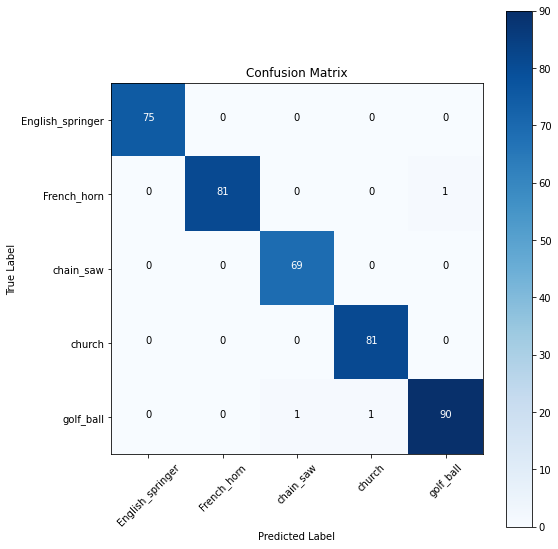

In [41]:
# Create a confusion matrix
confusion_mtx = confusion_matrix(labels_names, pred_labels_names, labels=classes) 
plot_confusion_matrix(confusion_mtx, classes = classes) 

#### Show some predictions

## From The confusion matrix, we found three pictures that are classified incorrectly so let us print these pictures.

In [42]:
corrects = torch.eq(labels, pred_labels)

In [43]:
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse=True, key=lambda x: torch.max(x[2], dim=0).values)

In [44]:
def plot_most_incorrect(incorrect, n_images):

    rows = 1 #int(np.sqrt(n_images))
    cols = n_images #int(np.sqrt(n_images))
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])

    fig = plt.figure(figsize=(15, 15))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        image, true_label, probs = incorrect[i]

        image = image.permute(1,2,0)
        image = image*std + mean
        image = np.clip(image,0,1)

        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim=0)
        ax.imshow(image, cmap='bone')
        # ax.imshow(image.view(image.size(0), -1).cpu().numpy(), cmap='bone')
        ax.set_title(f'True Label: {label_encoder.inverse_transform([true_label])[0]} ({true_prob:.3f})\n'
                     f'Pred Label: {label_encoder.inverse_transform([incorrect_label])[0]} ({incorrect_prob:.3f})')
        ax.axis('off')
    fig.subplots_adjust(hspace=0.5)

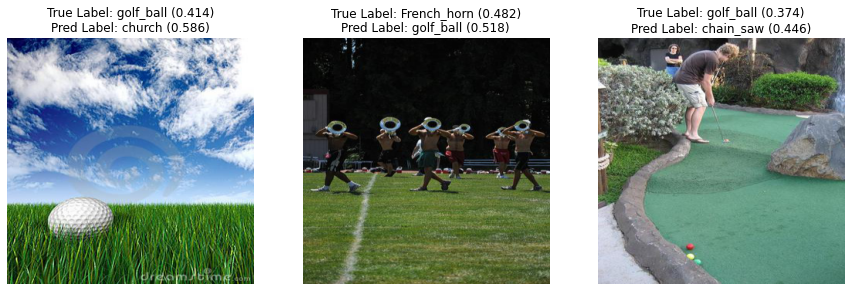

In [45]:
N_IMAGES = len(incorrect_examples)

plot_most_incorrect(incorrect_examples, N_IMAGES)

In [46]:
'''
Ideally, we want to select a model at the sweet spot between underfitting and overfitting.
The sweet spot is the point just before the error on the test dataset starts to increase
where the model has good skill on both the training dataset and the unseen test dataset.

Due to the transfer learning, the model's performance is quite good on both the trainning and test data.
'''